In [1]:
import os, math, saxpy
import numpy as np
import pandas as pd
from scipy import signal

os.chdir('/home/atom/cvlab/thesis/')
print(os.getcwd())

/home/atom/cvlab/thesis


## Load data 

In [2]:
from dataset.dataset import JumpPoseDataset

pose_paths = './dataset/marker_data'
info_path = './dataset/info.xlsx'
dataset = JumpPoseDataset(pose_paths, info_path, mode='vector')
poses, labels = zip(*dataset)

## Zero padding

In [3]:
def pad(vec, pad, max_len):
    pad_len = (max_len - len(pose)) / 2
    vec = np.insert(vec, 0, np.ones((math.floor(pad_len),vec.shape[1]))*pad, axis=0)
    vec = np.insert(vec, -1, np.ones((math.ceil(pad_len),vec.shape[1]))*pad, axis=0)
    return vec

## Truncating

In [4]:
def truncate(vec, min_len):
    return vec[:min_len]

## Resampling through interpolation

In [5]:
def resample(vec, size):
    vec = signal.resample(vec, size)
    return vec

## Randomized Time Warping

In [6]:
def TERMS(vec, num, size):
    vec = np.asarray([vec[sorted(np.random.randint(len(vec), size=size))] for _ in range(num)])
    if num == 1:
        return vec[0]
    else:
        return vec

## Symbolic Aggregate Approximation

In [7]:
from saxpy.znorm import znorm
from saxpy.sax import ts_to_string
from saxpy.alphabet import cuts_for_asize

def SAX(vec, size):
    return ts_to_string(znorm(vec[0]), cuts_for_asize(size))

SAX(poses[0], 20)

'dtkcljcpidsietkdticqiclictjcpjcqkdljdljdljdkiekjekjdkickiekjdtmctldthdtnckjctkdpidljetk'

## K-NN clustering 

In [10]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

parameters = {'n_neighbors':[2, 4, 8, 16]}
clf = GridSearchCV(KNeighborsClassifier(metric='euclidean'), parameters, cv=10, verbose=1, scoring='accuracy')

## Visualizations

In [12]:
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

def plot_2d(X, y, **kwargs):
    plt.style.use('ggplot')
    plt.subplot(2, 3, 1)
    pca = PCA(n_components=2).fit_transform(X)  
    plt.scatter(*pca.T, c=y)
    plt.xticks([], [])
    plt.yticks([], [])
    plt.title('PCA Plot')

    plt.subplot(2, 3, 2)
    lda = LinearDiscriminantAnalysis(n_components=None).fit_transform(X, y)
    plt.scatter(lda, range(len(lda)), c=y)
    plt.title('LDA Plot')
    plt.xticks([], [])
    plt.yticks([], [])

    plt.subplot(2, 3, 3)
    X_embedded = TSNE(n_components=2).fit_transform(X)
    plt.scatter(*X_embedded.T, c=y)
    plt.title('TSNE Plot')
    plt.xticks([], [])
    plt.yticks([], [])
    
    plt.suptitle(kwargs.pop('title'), fontsize='xx-large', y=1.05)
    plt.show()

## Tests

/home/atom/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


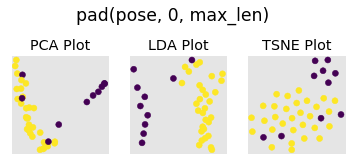

/home/atom/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


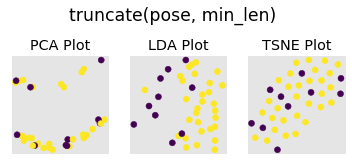

/home/atom/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


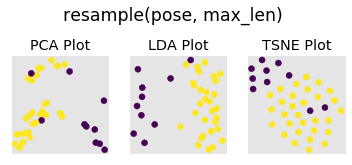

/home/atom/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


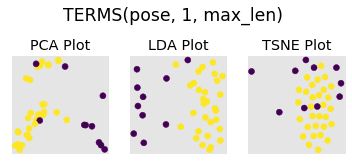

In [13]:
from sklearn.model_selection import train_test_split

max_len = max(map(len, poses))
min_len = min(map(len, poses))

func_dict = {
    0: 'pad(pose, 0, max_len)',
    1: 'truncate(pose, min_len)',
    2: 'resample(pose, max_len)',
    3: 'TERMS(pose, 1, max_len)'
}

for i in range(4):
    _X = []
    for pose in poses:
        _X.append(eval(func_dict[i]))
    
    _X = np.asarray(_X)
    X = _X.reshape(_X.shape[0], _X.shape[1]*_X.shape[2])
    y = np.asarray([label[0] for label in labels])
    plot_2d(X, y, title=func_dict[i])